In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [2]:
import itertools
import functools

def get_combinations(x,degree):
    return itertools.combinations_with_replacement(x,degree)
def compute_new_feature(items):
    return functools.reduce(lambda x,y:x*y,items)
def polynomial_transform(x,degree,logging=False):
    if x.ndim==1:
        x=x[:,None]
    x_t=x.transpose()
    features=[np.ones(len(x))]
    if logging:
        print("Input : ",x)
    for degree in range(1,degree+1):
        for items in get_combinations(x_t,degree):
            features.append(compute_new_feature(items))
            if logging:
                print(items," : ",compute_new_feature(items))
    if logging:
        print(np.asarray(features).transpose())
    return np.asarray(features).transpose()

Label Transformer Class

In [3]:
class LabelTransformer(object):
    # Label Encoder Decoder
    def __init__(self,n_classes:int=None):
        self.n_classes=n_classes
    
    @property
    def n_classes(self):
        return self.__n_classes
    
    @n_classes.setter
    def n_classes(self,K):
        self.__n_classes=K
        self.__encoder = None if K is None else np.eye(K)

    @property
    def encoder(self):
        return self.__encoder
    
    def encode(self,class_indices:np.ndarray):
        if self.n_classes is None:
            self.n_classes=np.max(class_indices)+1
        return self.encoder[class_indices]
    
    def decode(self,onhot:np.ndarray):
        return np.argmax(onehot,axis=1)

Function to create Dataset for Binary Classification

In [4]:
def create_toy_data(add_outliers=False,add_class=False):
    x0=np.random.normal(size=50).reshape(-1,2)-1
    x1=np.random.normal(size=50).reshape(-1,2)+1
    if add_outliers:
        x_1=np.random.normal(size=10).reshape(-1,2)+np.array([5.,10,])
        return np.concatenate([x0,x1,x_1]),np.concatenate([np.zeros(25),np.ones(30)]).astype(np.int)
    if add_class:
        x2=np.random.normal(size=50).reshape(-1,2)+2
        return np.concatenate([x0,x1,x2]),np.concatenate([np.zeros(25),np.ones(25),2+np.zeros(25)]).astype(np.int)
    return np.concatenate([x0,x1]),np.concatenate([np.zeros(25),np.ones(25)]).astype(np.int)

Function for Preprocessing the data

In [5]:
def preprocess(add_class=False,add_outliers=False,degree=1):
    x,y=create_toy_data(add_outliers,add_class)
    x_poly=polynomial_transform(x,degree)
    X_train, X_test, y_train, y_test = train_test_split(x_poly,y)
    y_train_trans=LabelTransformer().encode(y_train)
    y_test_trans=LabelTransformer().encode(y_test)
    return X_train, X_test, y_train, y_test,y_train_trans,y_test_trans

Function for visualizing the model

In [6]:
sns.set_context("notebook",font_scale=1.5,rc={"lines.linewidth":2.5})
def visualize_model(x_train,labels,lsc_obj,degree=1):
    f=plt.figure(figsize=(8,8))
    
    # compute xlim and ylim
    x1_min=np.min(x_train[:,1])
    x1_max=np.max(x_train[:,1])
    x2_min=np.min(x_train[:,2])
    x2_max=np.max(x_train[:,2])

    x1_test,x2_test=np.meshgrid(np.linspace(x1_min,x1_max,100),np.linspace(x2_min,x2_max,100))
    x_test=np.array([x1_test,x2_test]).reshape(2,-1).T
    x_test_poly=polynomial_transform(x_test,degree=degree)
    y_test=lsc_obj.predict(x_test_poly)

    sns.scatterplot(data=x_train,x=x_train[:,1],y=x_train[:,2],hue=labels)
    plt.contour(x1_test,x2_test,y_test.reshape(100,100),alpha=0.5,levels=np.linspace(0,1,3))
    plt.xlim=(x1_min,x1_max)
    plt.ylim(x2_min,x2_max)
    plt.gca().set_aspect('equal',adjustable='box')
    plt.show()


In [7]:
x_train, x_test, y_train, y_test,y_train_trans,y_test_trans=preprocess()

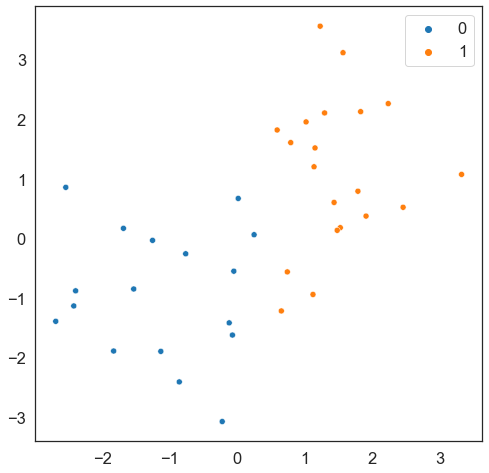

In [8]:
def visualize_data(x_train,y_train):
    sns.set_style("white")
    f=plt.figure(figsize=(8,8))
    sns.set_context("notebook",font_scale=1.5,rc={"lines.linewidth":2.5})
    sns.scatterplot(data=x_train,x=x_train[:,1],y=x_train[:,2],hue=y_train)
    plt.show()
visualize_data(x_train,y_train)

Least Squares Classification Class

In [9]:
class LeastSquaresClassification(object):
    def __init__(self):
        self.t0=20
        self.t1=1000
    
    def predict(self,X:np.ndarray)->np.ndarray:
        assert X.shape[-1]==self.w.shape[0],f"X shape {X.shape} and w shape {self.w.shape} are not compatible"
        return np.argmax(X@self.w,axis=-1)

    def predict_internal(self,X:np.ndarray)->np.ndarray:
        assert X.shape[-1]==self.w.shape[0],f"X shape {X.shape} and w shape {self.w.shape} are not compatible"
        return X@self.w
    
    def loss(self,X:np.ndarray,y:np.ndarray,reg_rate:float)->float:
        error=y-self.predict_internal(X)
        assert error.shape==y.shape, f'Predicted label shape {error.shape} and Actual label shape {y.shape}, are not compatible'
        return 0.5*np.transpose(error)@error+(reg_rate/2)*(np.transpose(self.w)@self.w)
       
    def fit(self,X:np.ndarray,y:np.ndarray,reg_rate:float)->np.ndarray:
        #self.w=np.zeros((X.shape[1]))
        eye=np.eye(np.size(X,1))
        self.w=np.linalg.solve( reg_rate*eye + X.T@X , X.T@y)
        return self.w

    def calculate_gradient(self,X:np.ndarray,y:np.ndarray,reg_rate:float)->np.ndarray:
        return np.transpose(X)@(self.predict_internal(X)-y) + reg_rate*self.w

    def update_weights(self,grad:np.ndarray,lr:float)->np.ndarray:
        return (self.w-lr*grad)
    
    def learning_schedule(self,t):
        return self.t0/(self.t1+t)
    
    def gradient_descent(self,X:np.ndarray,y:np.ndarray,num_epochs:int,lr:float,reg_rate:float)->np.ndarray:
        self.w=np.zeros((X.shape[-1],y.shape[-1]))
        self.w_all=[]
        self.err_all=[]
        for i in range(num_epochs):
            dJdW=self.calculate_gradient(X,y,reg_rate)
            self.w_all.append(self.w)
            self.err_all.append(self.loss(X,y,reg_rate))
            self.w=self.update_weights(dJdW,lr)
        return self.w
    
    def mini_batch_gradient_descent(self,X:np.ndarray,y:np.ndarray,num_epochs:int,batch_size:int,reg_rate:float)->np.ndarray:
        self.w=np.zeros((X.shape[-1],y.shape[-1]))
        self.w_all=[]
        self.err_all=[]
        mini_batch_id=0

        for epoch in range(num_epochs):
            shuffled_indices=np.random.permutation(X.shape[0])
            X_shuffled=X[shuffled_indices]
            y_shuffled=y[shuffled_indices]
            for i in range(0,X.shape[0],batch_size):
                mini_batch_id+=1
                xi=X_shuffled[i:i+batch_size]
                yi=y_shuffled[i:i+batch_size]
                
                self.w_all.append(self.w)
                self.err_all.append(self.loss(xi,yi,reg_rate))

                dJdW=(2/batch_size)*self.calculate_gradient(xi,yi,reg_rate)
                self.w=self.update_weights(dJdW,self.learning_schedule(mini_batch_id))
        return self.w

    def stochastic_gradient_descent(self,X:np.ndarray,y:np.ndarray,num_epochs:int,reg_rate:float)->np.ndarray:
        self.w=np.zeros((X.shape[-1],y.shape[-1]))
        self.w_all=[]
        self.err_all=[]

        for epoch in range(num_epochs):
            for i in range(X.shape[0]):
                random_index=np.random.randint(X.shape[0])
                xi=X[random_index:random_index+1]
                yi=y[random_index:random_index+1]

                self.w_all.append(self.w)
                self.err_all.append(self.loss(xi,yi,reg_rate))

                gradients=2*self.calculate_gradient(xi,yi,reg_rate)
                lr=self.learning_schedule(i)
                self.w=self.update_weights(gradients,lr)
        return self.w

In [10]:
lsc=LeastSquaresClassification()

[[ 0.53584755  0.46415245]
 [-0.22666305  0.22666305]
 [-0.08662748  0.08662748]]


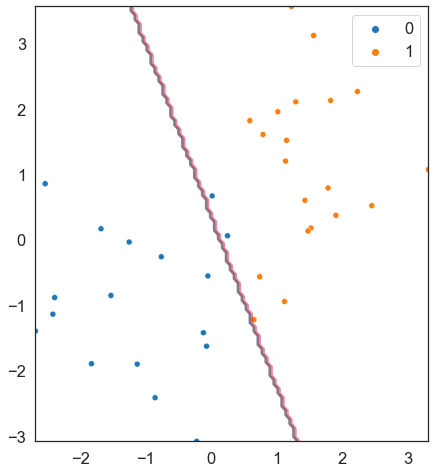

In [11]:
lsc.fit(x_train,y_train_trans,reg_rate=0)
print(lsc.w)
visualize_model(x_train,y_train,lsc)

In [12]:
def plot_learning_curve(err_all):
    err=[err[1][1] for err in err_all]
    plt.plot(np.arange(len(err)),err,'r-')

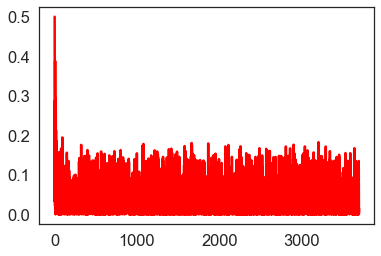

In [13]:
lsc.stochastic_gradient_descent(x_train,y_train_trans,num_epochs=100,reg_rate=0)
plot_learning_curve(lsc.err_all)

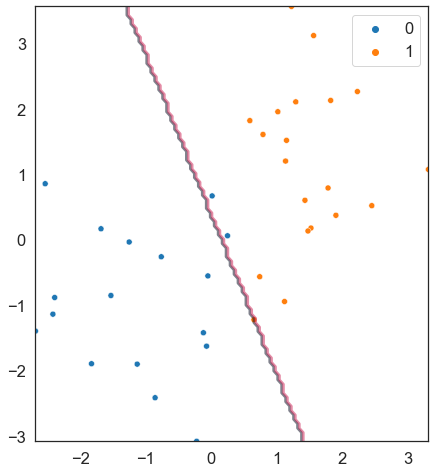

In [14]:
visualize_model(x_train,y_train,lsc)

Dataset that has outliers

In [15]:
x_train, x_test, y_train, y_test,y_train_trans,y_test_trans=preprocess(add_outliers=True)

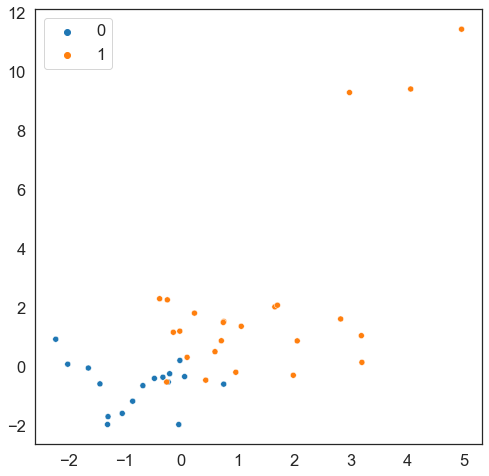

In [16]:
visualize_data(x_train,y_train)

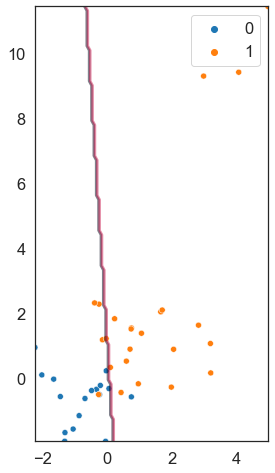

In [17]:
lsc_outlier=LeastSquaresClassification()
lsc_outlier.fit(x_train,y_train_trans,reg_rate=0)
visualize_model(x_train,y_train,lsc_outlier)

In [18]:
x_train, x_test, y_train, y_test,y_train_trans,y_test_trans=preprocess(add_class=True)

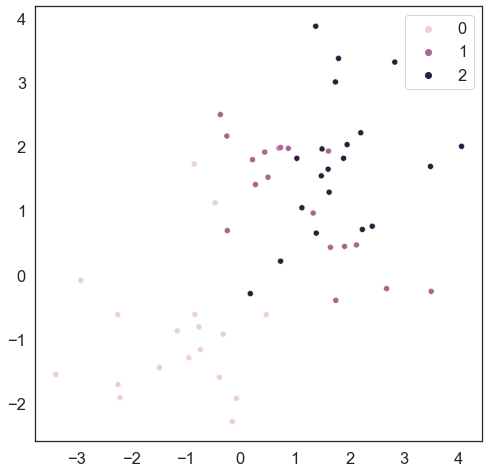

In [19]:
visualize_data(x_train,y_train)

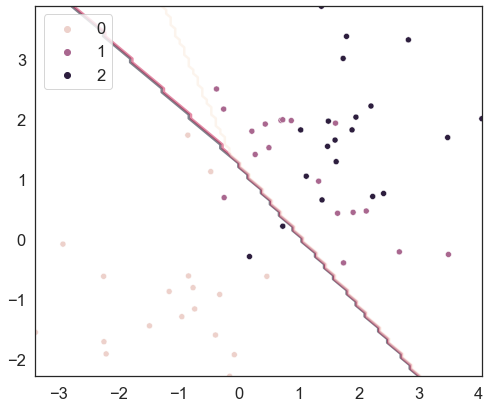

In [20]:
lsc_multi=LeastSquaresClassification()
lsc_multi.fit(x_train,y_train_trans,reg_rate=1)
visualize_model(x_train,y_train,lsc_multi)

In [21]:
from sklearn.metrics import classification_report
y_test_pred=lsc_multi.predict(x_test)
print(classification_report(y_test,y_test_pred,zero_division=0))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88         7
           1       0.00      0.00      0.00         7
           2       0.50      1.00      0.67         5

    accuracy                           0.63        19
   macro avg       0.43      0.67      0.51        19
weighted avg       0.42      0.63      0.50        19



Polynomial Least Square Classification

In [22]:
from sklearn.datasets import make_circles
x,y=make_circles()

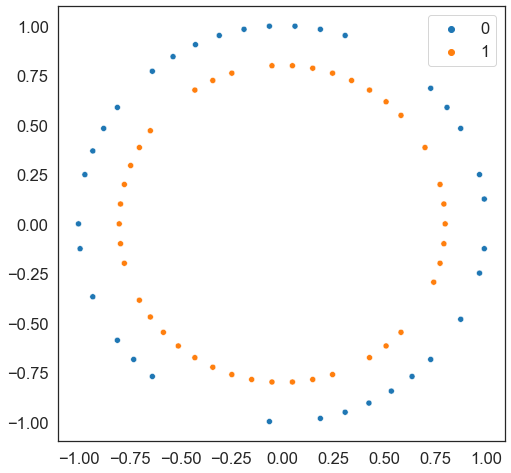

In [31]:
x_poly=polynomial_transform(x,degree=2)
x_train, x_test, y_train, y_test = train_test_split(x_poly,y)
visualize_data(x_train,y_train)

In [33]:
y_train_trans=LabelTransformer().encode(y_train)
y_test_trans=LabelTransformer().encode(y_test)

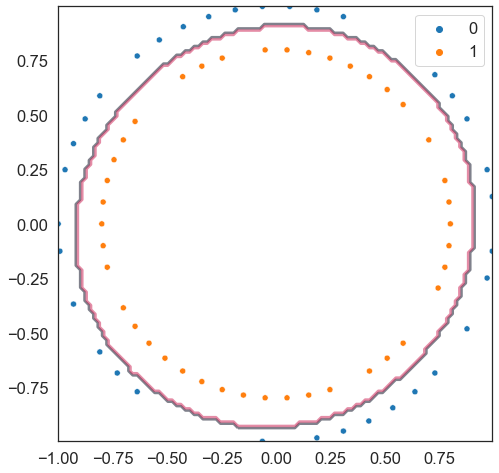

In [34]:
lsc_poly=LeastSquaresClassification()
lsc_poly.fit(x_train,y_train_trans,reg_rate=1)
visualize_model(x_train,y_train,lsc_poly,degree=2)